# SEP 769 - Deep Learning Project - Optimizing Energy Usage in Buildings Using IoT Data and Deep Learning Algorithms
> Hongqing Cao 400053625  
Sushant Shailesh Panchal 400614293  
Yanyi He 400651032  
Yash Parab 400611922

## Introduction
This project aims to develop a machine learning-based system to optimize energy usage in buildings using data from IoT sensors. The goal is to reduce energy consumption and costs while maintaining occupant comfort and health. The project involves preprocessing data from IoT sensors, developing a deep learning model to optimize energy usage, and testing the model on new data to evaluate its effectiveness.

The dataset [**Individual Household Electric Power Consumption dataset**](https://archive.ics.uci.edu/dataset/235) is retrived from UCI Machine Learning Repository, which contains measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available.

### Objectives
- Compare two different models over a subset of dataset, find the better performed model. 
- Tune, train, and evaluate the selected model, use this model to forecast future power consumption. 
- Visualize the predicted vs actual load, identify peak/vally power load time frames to suggest grid operation. 


### Dataset
- **Source**: UCI Machine Learning Repository (https://archive.ics.uci.edu/dataset/235).
- **Information**: This archive contains 2075259 measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months). 

- **Features**: 
    - `date: dd/mm/yyyy`
    - `time: hh:mm:ss`
    - `global_active_power: float` Total household active power usage in kilowatts (kW)
    - `reactive_power: float` Power not used for work, in KW
    - `voltage: float` Voltage across the circuit, in V
    - `global_intensity: float` Current drawn, in A
    - `sub_metering_1: float` Energy drawn for kitchen, in Wh
    - `sub_metering_2: float` Energy drawn for laundry, in Wh
    - `sub_metering_3: float` Energy drawn for water heater and AC, in Wh

- **Note**:  
`global_active_power * 1000 / 60 - sub_metering_1 - sub_metering_2 - sub_metering_3`  
represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3.

- **Missing Data**: The dataset contains some missing values in the measurements (nearly 1,25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing (willed with `?`). 

### References
- Marino et al. (2016), *Building Energy Load Forecasting using Deep Neural Networks*. 
- Bonetto & Rossi (2017), *Machine Learning Approaches to Energy Consumption Forecasting in Households*. 
- Gasparin et al. (2019), *Deep Learning for Time Series Forecasting: The Electric Load Case*. 

### Essential Notes
- **Hardware**: The code in notebook in designed to best perform with CUDA GPUs, targeting RTX 4070. 

- **Environment**: Use `Python 3.11.7`, `NVIDIA-SMI 575.64.04`, `Driver Version: 577.00`, `CUDA Version: 12.9`. 

## 0. Environment Setup
### Libaries Imported
`numpy 2.1.3`  
`matplotlib 3.10.3`  
`pandas 2.3.1`  
`tensorflow 2.19.0`  
`scikit-learn 1.7.1`  
`keras 3.10.0`  
`tensorboard 2.19.0`  
`seaborn 0.13.2`  

### GPU Config
set `set_memory_growth`, `mixed_precision`

### Utility Functions
``

In [195]:
### Libaries Imported
from os import path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from tensorflow import keras
from keras import Sequential, layers, Model
from keras import backend as K
from keras.optimizers import Adam
from tensorboard.plugins.hparams import api as hp
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import mixed_precision
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import gc

%load_ext tensorboard

np.random.seed(42)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [91]:
### GPU Config
# use set_memory_growth to aallocate VRAM

gpus = tf.config.list_physical_devices('GPU')

if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

# use mixed_precision to accelrate GPU speed

mixed_precision.set_global_policy('mixed_float16')

In [92]:
### Global Variables
DATA_DIR = "data"
RAW_DIR = DATA_DIR+"/raw"
TRAIN_DIR = DATA_DIR+"/train"
TEST_DIR = DATA_DIR+"/test"

MODEL_DIR = "model"

LOG_DIR = "log"
HPARAM_DIR = LOG_DIR+"/hparam"

In [160]:
### Utility functions

def delete_model(modelname, historyname):
    '''function for delete model, history and free vram'''
    global_vars = globals()
    if modelname in globals():
        del global_vars[modelname]
    if historyname in globals():
        del global_vars[historyname]
    gc.collect()
    K.clear_session()

def inspect_data(df, name):
    '''print summary data of a given dataframe, with
    count
    mean
    std
    min
    25%
    50%
    75%
    max
    dtype
    '''
    print(f"\n{name} summary:")
    print(df.describe())
    print(df.isnull().sum())

def plot_time_series(df, column, start=None, end=None, title=None):
    '''plot the raw time series data from time to end with corresponding column

    column =  global_active_power, sub_metering_other, sub_metering_1/2/3'''
    df_subset = df[start:end] if start or end else df
    df_subset[column].plot(figsize=(12, 4), title=title or column)

# def plot_hourly_avg(df, column):
#     hourly_avg = df.groupby(df.index.hour)[column].mean()
#     hourly_avg.plot(kind="bar", figsize=(10, 4), title=f"Average {column} by Hour")

# def plot_dayofweek_avg(df, column):
#     dow_avg = df.groupby(df.index.dayofweek)[column].mean()
#     dow_avg.plot(kind="bar", figsize=(8, 4), title=f"Average {column} by Day of Week")

# def plot_distribution(df, column):
#     df[column].hist(bins=50, figsize=(6, 4), title=f"Distribution of {column}")

# def plot_correlation_heatmap(df):
#     plt.figure(figsize=(10, 6))
#     sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
#     plt.title("Feature Correlation Heatmap")

# def plot_lagged_sample(X, y, feature_idx=0, sample_idx=0):
#     '''Visualize what an LSTM/S2S input-output pair looks like'''
#     plt.plot(X[sample_idx, :, feature_idx], label="Input sequence")
#     plt.axhline(y[sample_idx], color='r', linestyle='--', label="Target")
#     plt.legend()
#     plt.title("Lagged input and target")
#     plt.show()

def plot_loss(history, maxy=None):
    '''Loss during training'''
    loss = history.history['loss']
    test_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss)
    plt.plot(epochs, test_loss)
    if maxy:
        plt.ylim(0, maxy)
    plt.title('Loss')
    plt.grid()
    plt.figure()

def plot_forecast(y_true, y_pred, title="Forecast vs Actual"):
    '''plot forecast vs actual lines'''
    plt.figure(figsize=(12, 4))
    plt.plot(y_true, label="Actual")
    plt.plot(y_pred, label="Forecast")
    plt.title(title)
    plt.legend()
    plt.show()


## 1. Data Preprocessing

### Load Data
 - Load raw dataset
 - Convert data type

### Resample Data
Resample data to 1-hr

### Handle Missing Data
Reconstruct misssing data with linear interpolation

### Save Raw Data
Save to `data/raw`

### Feature Engineering
 - `season_spring: binary` one-hot coded season transformed from `date`
 - `season_summer: binary` one-hot coded season transformed from `date`
 - `season_autumn: binary` one-hot coded season transformed from `date`
 - `season_winter: binary` one-hot coded season transformed from `date`
 - `day_of_week: int` categorical in `range(7)`, 0 Sunday, 1 Monday, 6 Saturday
 - `hour_sin, hour_cos: float` hour in transfromed from `time` in cyclical encoding, range [-1, 1]
 - `global_active_power: float` target variable, 
 - `sub_metering_other: float` calculated by `global_active_power * 1000 / 60 - sub_metering_1 - sub_metering_2 - sub_metering_3`, 
 - `reactive_power: float` drop
 - `voltage: float` drop
 - `global_intensity: float` drop
 - `sub_metering_1: float` existing raw feature
 - `sub_metering_2: float` existing raw feature
 - `sub_metering_3: float` existing raw feature

### Save Feature Engineered Data
Save to `data/raw`

### Create Subsets (distinct)
 - `model_selection`: 3 month (~2100 samples)
 - `hparam_tuning`: 3 month (~2100 samples)
 - `train`: 24 months (~17000 samples)
 - `test`: 3 months (~2100 samples)
 - `test_1`: 3 months (~2100 samples) forecast
 - `test_2`: 3 months (~2100 samples) forecast

### Save Subset Data
 - Store model selection, tuning, training data in `data/train` 
 - Store  testing data in `data/test` 

### Normalization and Standarization
Use `StandardScaler` for `global_active_power`, `sub_metering_other`, `sub_metering_1`, `sub_metering_2`, `sub_metering_3` 

### Save Normalized Data
Store model selection, tuning, training data in `data/train` 

### Lagging Data
Lag data by 1 weel = 168 hrs = 168 samples. 
Specify target variable 

### Save Final Processed Data
 - Store raw data in `/data/raw` 
 - Store model selection, tuning, training data in `data/train` 
 - Store  testing data in `data/test` 
 - Store models in `model` 
 - Store hyperparameter tuning log in `log/hparam`. 

In [138]:
### Load Data
# Load raw data
chunks = []
reader = pd.read_csv(
    RAW_DIR+"/household_power_consumption.txt", 
    sep=";", 
    na_values='?',
    low_memory=False,
    chunksize=500_000
    )

for chunk in reader:
    chunks.append(chunk)

df = pd.concat(chunks)

df.columns = df.columns.str.lower()
df['datetime_str'] = df['date'] + ' ' + df['time']

df['datetime'] = (pd.to_datetime(df['datetime_str'], dayfirst=True))
df = df.drop(columns=['date', 'time', 'datetime_str'])
df.set_index("datetime", inplace=True)
df.sort_index(inplace=True)

# Convert from string/object to float
df = df.astype(np.float32)

In [140]:
inspect_data(df, 'raw data')


raw data summary:
       global_active_power  global_reactive_power       voltage  \
count         2.049280e+06           2.049280e+06  2.049280e+06   
mean          1.091615e+00           1.237144e-01  2.408399e+02   
std           1.057294e+00           1.127220e-01  3.239987e+00   
min           7.600000e-02           0.000000e+00  2.232000e+02   
25%           3.080000e-01           4.800000e-02  2.389900e+02   
50%           6.020000e-01           1.000000e-01  2.410100e+02   
75%           1.528000e+00           1.940000e-01  2.428900e+02   
max           1.112200e+01           1.390000e+00  2.541500e+02   

       global_intensity  sub_metering_1  sub_metering_2  sub_metering_3  
count      2.049280e+06    2.049280e+06    2.049280e+06    2.049280e+06  
mean       4.627760e+00    1.121923e+00    1.298520e+00    6.458447e+00  
std        4.444396e+00    6.153031e+00    5.822026e+00    8.437154e+00  
min        2.000000e-01    0.000000e+00    0.000000e+00    0.000000e+00  
25%    

In [95]:
### Resample Data
# Resample to hourly mean
df_hourly = df.resample('h').mean()

In [96]:
### Handle Missing Data
df_hourly_reco = df_hourly.interpolate(method='linear', limit_direction='both')
df_hourly_reco.dropna(inplace=True)

In [141]:
inspect_data(df_hourly_reco, 'reconstructed data')


reconstructed data summary:
       global_active_power  global_reactive_power       voltage  \
count         34589.000000           34589.000000  34589.000000   
mean              1.092488               0.123710    240.828400   
std               0.895746               0.066998      3.002928   
min               0.124000               0.000000    225.834503   
25%               0.343433               0.078067    239.174835   
50%               0.806833               0.106833    240.974670   
75%               1.578233               0.149367    242.687668   
max               6.560533               0.774333    251.902008   

       global_intensity  sub_metering_1  sub_metering_2  sub_metering_3  \
count      34589.000000    34589.000000    34589.000000    34589.000000   
mean           4.631340        1.123029        1.291784        6.445877   
std            3.749644        3.534986        4.170525        7.332015   
min            0.503333        0.000000        0.000000        0.00

In [97]:
# Save raw data
df_hourly_reco.to_pickle(RAW_DIR+"/hourly_reco.pkl")


In [98]:
# Load raw data
df_hourly_reco = pd.read_pickle(RAW_DIR+"/hourly_reco.pkl")

In [99]:
### Feature Engineering
df_hourly_reco['month'] = df_hourly_reco.index.month
df_hourly_reco['season'] = df_hourly_reco.index.month % 12 // 3 
# 1=spring, 2=summer, 3=fall, 0=winter

season_map = {0: 'winter', 1: 'spring', 2: 'summer', 3: 'autumn'}
df_hourly_reco['season_label'] = df_hourly_reco['season'].map(season_map)

df_hourly_reco = pd.get_dummies(df_hourly_reco, columns=['season_label'], prefix='season')

dow_mon0 = df_hourly_reco.index.dayofweek # 0=Monday
dow_sun0 = (dow_mon0 + 1) % 7 # 0=Sunday
df_hourly_reco['day_of_week'] = dow_sun0 # 0=Sunday


df_hourly_reco['hour'] = df_hourly_reco.index.hour
# For smoother time-of-day signals:
df_hourly_reco['hour_sin'] = np.sin(2 * np.pi * df_hourly_reco['hour'] / 24)
df_hourly_reco['hour_cos'] = np.cos(2 * np.pi * df_hourly_reco['hour'] / 24)

df_hourly_reco['sub_metering_other'] = (
    df_hourly_reco['global_active_power'] * 1000 / 60
    - df_hourly_reco['sub_metering_1']
    - df_hourly_reco['sub_metering_2']
    - df_hourly_reco['sub_metering_3']
)

df_fe = df_hourly_reco.copy()

In [100]:
### Feature Engineering Continued
drop_cols = ['month', 'season', 'hour', 'voltage', 'global_reactive_power', 'global_intensity']
df_fe.drop(columns=drop_cols, inplace=True)

In [142]:
inspect_data(df_fe, 'feature engineered data')


feature engineered data summary:
       global_active_power  sub_metering_1  sub_metering_2  sub_metering_3  \
count         34589.000000    34589.000000    34589.000000    34589.000000   
mean              1.092488        1.123029        1.291784        6.445877   
std               0.895746        3.534986        4.170525        7.332015   
min               0.124000        0.000000        0.000000        0.000000   
25%               0.343433        0.000000        0.000000        0.650000   
50%               0.806833        0.000000        0.333333        1.666667   
75%               1.578233        0.000000        0.650000       14.066667   
max               6.560533       48.366665       46.433334       21.549999   

        day_of_week      hour_sin      hour_cos  sub_metering_other  
count  34589.000000  34589.000000  3.458900e+04        34589.000000  
mean       2.998410     -0.000130  3.489857e-05            9.347441  
std        1.999414      0.707150  7.070840e-01      

In [101]:
### Save Feature Engineered Data
df_fe.to_pickle(RAW_DIR+"/feature_engineered.pkl")


In [143]:
### Load Feature Engineered Data
df_fe=pd.read_pickle(RAW_DIR+"/feature_engineered.pkl")

In [144]:
### Create Subsets (distinct)
total_len = len(df_fe)

# Subset sizes (in number of rows)
model_sel_len = 2160     # 3 month
tune_len      = 2160     # 3 month
train_len     = 17520    # 24 months
test_len      = 2160    # 3 months

# Sequential slicing
model_sel_df = df_fe.iloc[:model_sel_len]

tune_df = df_fe.iloc[model_sel_len : model_sel_len + tune_len]

train_df = df_fe.iloc[model_sel_len + tune_len : model_sel_len + tune_len + train_len]

test_df = df_fe.iloc[model_sel_len + tune_len + train_len : model_sel_len + tune_len + train_len + test_len]

test1_start = 27000

test1_df = df_fe[test1_start : test1_start + test_len]
test2_df = df_fe[test1_start + test_len + test_len : test1_start + test_len + test_len + test_len]


In [145]:
### Save Subsets
model_sel_df.to_pickle(TRAIN_DIR+"/model_selection.pkl")
tune_df.to_pickle(TRAIN_DIR+"/hparam_tuning.pkl")
train_df.to_pickle(TRAIN_DIR+"/train.pkl")
test_df.to_pickle(TEST_DIR+"/test.pkl")
test1_df.to_pickle(TEST_DIR+"/test1.pkl")
test2_df.to_pickle(TEST_DIR+"/test2.pkl")


In [146]:
### Load Subsets
model_sel_df = pd.read_pickle(TRAIN_DIR+"/model_selection.pkl")
tune_df = pd.read_pickle(TRAIN_DIR+"/hparam_tuning.pkl")
train_df = pd.read_pickle(TRAIN_DIR+"/train.pkl")
test_df = pd.read_pickle(TEST_DIR+"/test.pkl")
test1_df = pd.read_pickle(TEST_DIR+"/test1.pkl")
test2_df = pd.read_pickle(TEST_DIR+"/test2.pkl")

In [149]:
[model_sel_df.shape, tune_df.shape, train_df.shape, test_df.shape, test1_df.shape, test2_df.shape]

[(2160, 12), (2160, 12), (17520, 12), (2160, 12), (2160, 12), (2160, 12)]

In [129]:
### Normalization and Standarization
cols_to_scale = ['global_active_power', 'sub_metering_other', 'sub_metering_1', 'sub_metering_2', 'sub_metering_3']

scaler = StandardScaler()
scaler.fit(train_df[cols_to_scale])

def std_scale(df, scaler, cols_to_scale):
    df_scaled = df.copy()
    df_scaled[cols_to_scale] = scaler.transform(df[cols_to_scale])
    return df_scaled


model_sel_scaled = std_scale(model_sel_df, scaler, cols_to_scale)
tune_scaled = std_scale(tune_df, scaler, cols_to_scale)
train_scaled = std_scale(train_df, scaler, cols_to_scale)
test_scaled = std_scale(test_df, scaler, cols_to_scale)
test1_scaled = std_scale(test1_df, scaler, cols_to_scale)
test2_scaled = std_scale(test2_df, scaler, cols_to_scale)

In [130]:
### Save Normalized Data
model_sel_scaled.to_pickle(TRAIN_DIR+"/model_selection_scaled.pkl")
tune_scaled.to_pickle(TRAIN_DIR+"/hparam_tuning_scaled.pkl")
train_scaled.to_pickle(TRAIN_DIR+"/train_scaled.pkl")
test_scaled.to_pickle(TEST_DIR+"/test_scaled.pkl")
test1_scaled.to_pickle(TEST_DIR+"/test1_scaled.pkl")
test2_scaled.to_pickle(TEST_DIR+"/test2_scaled.pkl")


In [131]:
### Load Normalized Data
model_sel_scaled = pd.read_pickle(TRAIN_DIR+"/model_selection_scaled.pkl")
tune_scaled = pd.read_pickle(TRAIN_DIR+"/hparam_tuning_scaled.pkl")
train_scaled = pd.read_pickle(TRAIN_DIR+"/train_scaled.pkl")
test_scaled = pd.read_pickle(TEST_DIR+"/test_scaled.pkl")
test1_scaled = pd.read_pickle(TEST_DIR+"/test1_scaled.pkl")
test2_scaled = pd.read_pickle(TEST_DIR+"/test2_scaled.pkl")

In [136]:
train_scaled.columns

Index(['global_active_power', 'sub_metering_1', 'sub_metering_2',
       'sub_metering_3', 'season_autumn', 'season_spring', 'season_summer',
       'season_winter', 'day_of_week', 'hour_sin', 'hour_cos',
       'sub_metering_other'],
      dtype='object')

In [172]:
### Lagging Data

def create_lagged_sequences(df, target_col, lag_size=168, forecast_horizon=24):
    features = df.drop(columns=[target_col]).values
    target = df[target_col].values

    num_samples = len(df) - lag_size - forecast_horizon + 1
    num_features = features.shape[1]

    X = np.zeros((num_samples, lag_size, num_features), dtype=np.float32)
    y = np.zeros((num_samples, forecast_horizon, 1), dtype=np.float32)

    for i in range(num_samples):
        X[i] = features[i : i + lag_size]
        y[i,:,0] = target[i + lag_size : i + lag_size + forecast_horizon]

    return X, y

target_col='global_active_power'


X_model_sel, y_model_sel = create_lagged_sequences(model_sel_scaled, target_col)
X_tune, y_tune = create_lagged_sequences(tune_scaled, target_col)
X_train, y_train = create_lagged_sequences(train_scaled, target_col)
X_test, y_test = create_lagged_sequences(test_scaled, target_col)
X_test1, y_test1 = create_lagged_sequences(test1_scaled, target_col)
X_test2, y_test2= create_lagged_sequences(test2_scaled, target_col)

In [173]:
### Save Processed Data
np.save(TRAIN_DIR+"/X_model_sel.npy", X_model_sel)
np.save(TRAIN_DIR+"/y_model_sel.npy", y_model_sel)
np.save(TRAIN_DIR+"/X_tune.npy", X_tune)
np.save(TRAIN_DIR+"/y_tune.npy", y_tune)
np.save(TRAIN_DIR+"/X_train.npy", X_train)
np.save(TRAIN_DIR+"/y_train.npy", y_train)
np.save(TRAIN_DIR+"/X_test.npy", X_test)
np.save(TRAIN_DIR+"/y_test.npy", y_test)
np.save(TRAIN_DIR+"/X_test1.npy", X_test1)
np.save(TRAIN_DIR+"/y_test1.npy", y_test1)
np.save(TRAIN_DIR+"/X_test2.npy", X_test2)
np.save(TRAIN_DIR+"/y_test2.npy", y_test2)

In [174]:
### Load Processed Data
X_model_sel = np.load(TRAIN_DIR+"/X_model_sel.npy")
y_model_sel = np.load(TRAIN_DIR+"/y_model_sel.npy")

X_tune = np.load(TRAIN_DIR+"/X_tune.npy")
y_tune = np.load(TRAIN_DIR+"/y_tune.npy")

X_train = np.load(TRAIN_DIR+"/X_train.npy")
y_train = np.load(TRAIN_DIR+"/y_train.npy")

X_test = np.load(TRAIN_DIR+"/X_test.npy")
y_test = np.load(TRAIN_DIR+"/y_test.npy")

X_test1 = np.load(TRAIN_DIR+"/X_test1.npy")
y_test1 = np.load(TRAIN_DIR+"/y_test1.npy")

X_test2 = np.load(TRAIN_DIR+"/X_test2.npy")
y_test2 = np.load(TRAIN_DIR+"/y_test2.npy")

In [175]:
[(X_model_sel.shape, y_model_sel.shape), (X_tune.shape, y_tune.shape), (X_train.shape, y_train.shape), (X_test.shape, y_test.shape), (X_test1.shape, y_test1.shape), (X_test2.shape, y_test2.shape)]

[((1969, 168, 11), (1969, 24, 1)),
 ((1969, 168, 11), (1969, 24, 1)),
 ((17329, 168, 11), (17329, 24, 1)),
 ((1969, 168, 11), (1969, 24, 1)),
 ((1993, 168, 11), (1993, 24, 1)),
 ((2041, 168, 11), (2041, 24, 1))]

## 2. Model Selection
Train both model with `model_selection` subset with `validation_split = 0.2`. 

### LSTM

### S2S
Seq2seq 

### Evaluation
Use $\mathrm{RMSE}$ to compare models

### Save Model
Save both models in `model`


In [185]:
### LSTM
def build_LSTM(input_shape, units=64, dropout_rate=0.2, learning_rate = 0.001):
    model = Sequential([
        layers.Input(shape=input_shape),
        layers.LSTM(units),
        layers.Dropout(dropout_rate),
        layers.Dense(units=int(units/2), activation='relu'),
        layers.Dense(24)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    return model

In [ ]:
# ### S2S
class Encoder(layers.Layer):
    def __init__(self, units):
        super(Encoder, self).__init__()
        self.units = units
        self.lstm = layers.LSTM(
            units,
            return_state = True, 
        )

    def call(self, X):
        output, state_h, state_c = self.lstm(X)
        return output, [state_h, state_c]
class Decoder(layers.Layer):
    def __init__(self, output_shape, units):
        super(Decoder, self).__init__()
        self.output_shape = output_shape
        self.units = units
        self.lstm = layers.LSTM(
            units,
            return_sequences=True,
            return_state=True,
        )
        self.dense  = layers.Dense(output_shape)

    def call(self, X, initial_state=None, return_state=False):
        lstm_out, state_h, state_c = self.lstm(X, initial_state=initial_state)
        output = self.dense(lstm_out)

        if return_state:
            return output, [state_h, state_c]
        else:
            return output
class Seq2SeqEncoder(Model):  #@save
    def __init__(self, encoder_units, decoder_units, output_shape):
        super().__init__()
        self.encoder = Encoder(encoder_units)
        self.decoder = Decoder(decoder_units, output_shape)

    def call(self, endocoder_input, decoder_input):
        _, states = self.encoder(endocoder_input)
        output = self.decoder(decoder_input, initial_state=states)
        return output

In [186]:
delete_model('model_sel_LSTM', 'history_sel_LSTM')

input_shape = X_model_sel.shape[1:]
output_shape = y_model_sel.shape[1:]

model_sel_LSTM = build_LSTM(input_shape)
model_sel_LSTM.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │           792 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,328 (87.22 KB)

 Trainable params: 22,328 (87.22 KB)

 Non-trainable params: 0 (0.00 B)

In [187]:
### Train Each Model
check_point = ModelCheckpoint(
    MODEL_DIR + '/model_sel_LSTM_best.keras',
    monitor='val_loss',
    save_best_only=True
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)


history_sel_LSTM = model_sel_LSTM.fit(
    X_model_sel, y_model_sel,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    shuffle=False,
    callbacks=[check_point, early_stop]
)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 1.8548 - mae: 1.0895 - val_loss: 1.4571 - val_mae: 1.0275
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 1.5916 - mae: 1.0314 - val_loss: 1.4118 - val_mae: 1.0172
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.4921 - mae: 1.0006 - val_loss: 1.3693 - val_mae: 1.0026
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.4479 - mae: 0.9822 - val_loss: 1.3339 - val_mae: 0.9903
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.4052 - mae: 0.9646 - val_loss: 1.3064 - val_mae: 0.9794
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.3660 - mae: 0.9495 - val_loss: 1.2672 - val_mae: 0.9619
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.3270 - mae: 0.9309 - val_loss: 1.2186 - val_mae: 0.9382
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.2929 - mae: 0.9142 - val_loss: 1.1721 - val_mae: 0.9123
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - lo

In [189]:
history_sel_LSTM.history

{'loss': [1.6878901720046997,
  1.5133347511291504,
  1.4374468326568604,
  1.39424729347229,
  1.3517628908157349,
  1.3107898235321045,
  1.267655372619629,
  1.2304586172103882,
  1.1834887266159058,
  1.141417384147644,
  1.0980939865112305,
  1.0629234313964844,
  1.0548807382583618,
  1.0063903331756592,
  0.9722175598144531,
  1.0257978439331055,
  1.0148335695266724,
  0.9454310536384583,
  0.9179813265800476,
  0.8933376669883728,
  0.8648500442504883,
  0.8495274782180786,
  0.8426898121833801,
  0.8258791565895081,
  0.8822367787361145,
  0.8467507362365723,
  0.7832337617874146,
  0.7626651525497437,
  0.7592198848724365,
  0.7510872483253479,
  0.7281994223594666,
  0.7786625027656555,
  0.7599998712539673,
  0.7101026177406311,
  0.692390501499176,
  0.6855840682983398,
  0.6677895784378052],
 'mae': [1.0430042743682861,
  1.0043840408325195,
  0.9795826077461243,
  0.962035059928894,
  0.9432162046432495,
  0.9265102744102478,
  0.9057007431983948,
  0.8871893882751465,


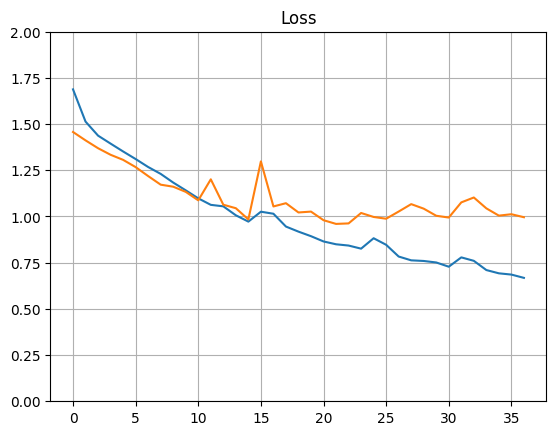

<Figure size 640x480 with 0 Axes>

In [188]:
plot_loss(history_sel_LSTM,maxy=2.0)

In [190]:
### Evaluation
model_sel_LSTM_b = load_model(MODEL_DIR+'/model_sel_LSTM_best.keras')
pred_sel_LSTM = model_sel_LSTM.predict(X_test)



62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


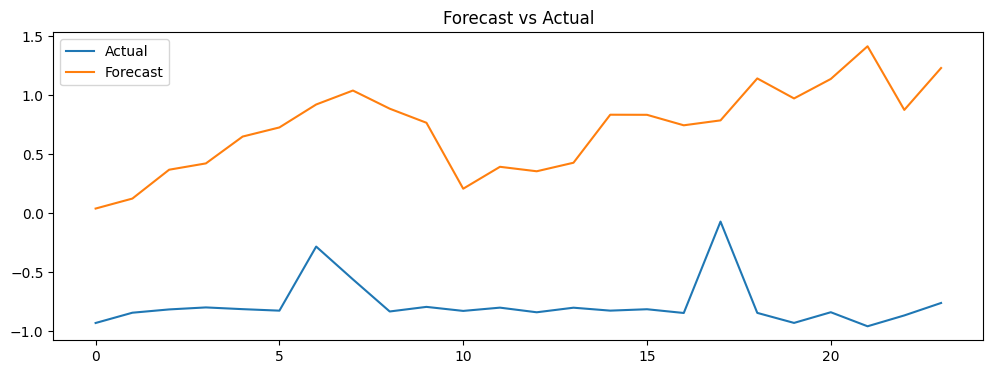

In [192]:
plot_forecast(y_test[0], pred_sel_LSTM[0])

In [201]:
# ### S2S
class Encoder(layers.Layer):
    def __init__(self, units):
        super(Encoder, self).__init__()
        self.units = units
        self.lstm = layers.LSTM(
            units,
            return_state = True, 
        )

    def call(self, X):
        output, state_h, state_c = self.lstm(X)
        return output, [state_h, state_c]

class Decoder(layers.Layer):
    def __init__(self, units):
        super(Decoder, self).__init__()
        self.units = units
        self.lstm = layers.LSTM(
            units,
            return_sequences=True,
            return_state=True,
        )
        self.dense  = layers.Dense(1)

    def call(self, X, initial_state=None, return_state=False):
        lstm_out, state_h, state_c = self.lstm(X, initial_state=initial_state)
        output = self.dense(lstm_out)

        if return_state:
            return output, [state_h, state_c]
        else:
            return output

class Seq2SeqEncoder(Model):  #@save
    def __init__(self, encoder_units, decoder_units):
        super().__init__()
        self.encoder = Encoder(encoder_units)
        self.decoder = Decoder(decoder_units)

    def call(self, encoder_input, decoder_input):
        _, states = self.encoder(encoder_input)
        output = self.decoder(decoder_input, initial_state=states)
        return output

In [205]:
delete_model('model_sel_S2S', 'history_sel_S2S')
decoder_input = np.zeros_like(y_model_sel)
decoder_input[:, 1:, :] = y_model_sel[:, :-1, :]

output_shape = y_model_sel.shape[1:-1]

model_sel_S2S = Seq2SeqEncoder(64, 24)


In [ ]:
model_sel_S2S.compile(optimizer='adam', loss='mse', metrics=['mae'])

check_point = ModelCheckpoint(
    MODEL_DIR + '/model_sel_S2S_best.keras',
    monitor='val_loss',
    save_best_only=True
)
model_sel_S2S.fit(
    [X_model_sel, decoder_input], 
    y_model_sel,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks = [early_stop, check_point],
    shuffle=False
)

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 13863, 1969
'y' sizes: 13863


## 3. Model Train
### Hyperparameter Tuning
Tune hyperparameters on `hparam_tuning` subset with `validation_split = 0.2`. 

Hyperparameters to be tuned:
 - `learning_rate`
 - `num_layers`
 - `hidden_size`
 - `dropout`
 - `etc`

Save logs in `log/hparam`

### Train Tuned Model
Train model on `train` subset with `validation_split = 0.2`. 

### Save Model
Save model in `model`. 

In [ ]:
### Hyperparameter Tuning
# delete hyperparameter tuning logs
%rm -rf ./logs/hparam_tuning/

In [ ]:
# Tuning hyperparameters 
# learning rate [0.0001, 0.001]
# dropout [0.4, 0.5]
# optimizer ['adam', 'rmsprop', 'SGD']
# batch size [64, 128, 256]

# map optimizer str and class obj in a dict
OPTIMIZER_MAP = {
    'adam': Adam,
    'rmsprop': RMSprop,
    'SGD': SGD
}

HP_LR = hp.HParam('learning_rate', hp.Discrete([0.0001, 0.001]))
HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.4, 0.5]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'rmsprop', 'SGD']))
HP_BATCH_SIZE = hp.HParam('batch_size', hp.Discrete([64, 128, 256]))

METRIC_ACCURACY = 'accuracy'

# initiate tfboard log
with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
        hparams=[HP_LR, HP_DROPOUT, HP_OPTIMIZER, HP_BATCH_SIZE],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
    )

In [121]:
### Train Tuned Model


In [122]:
### Save Model


## 4. Model Evaluation

### Evaluate Model
Use `test` subset to evaluate model with metrics $\mathrm{RMSE}$ and $\mathrm{MAE}$. 

### Visualization
Plots to be visualized
 - Actual vs Predicted 
 - Loss over Epochs

### Analyze Model Performance


In [123]:
### Evaluate Model

In [124]:
### Visualization

In [125]:
### Analyze Model Performance


## 5. Forecaste to Energy Optimization

### Use `test1` and `test2` subset, take one day/week ahead, predict the `global_active_power` of the subset. 

### Merics
RMSE, MAE

### Visualize Result
Predicted vs Actual
